# Cleaning the newspaper archive

In [17]:
import os
import re
import json
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial
from itertools import product
from collections import Counter
from unicodedata import category
from multiprocessing import cpu_count
from utils import multicore_apply

import fasttext
from umap import UMAP
from scipy.linalg import norm
from reo_toolkit import is_maori
from gensim.models import Phrases
from nltk.tokenize import word_tokenize, sent_tokenize

import warnings
from numba.errors import NumbaWarning
warnings.filterwarnings("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = NumbaWarning)

In [18]:
def remove_punctuation(text):
    return ''.join(ch for ch in text if category(ch)[0] != 'P')
    
def normalize_text(text):
    text = re.sub("\s{2,}", " ", text)
    return remove_punctuation(text.lower())

## Cleaning the text

In [19]:
with open('../data/maori_newspapers.json', 'r') as f:
    papers = pd.DataFrame(json.load(f))

In [20]:
col_patterns = {
    'newspaper_id': '([A-Z]+)[^/]+$',
    'year': '[A-Z]+([0-9]{4})[^/]+$',
    'month': '[A-Z]+[0-9]{4}([0-9]{2})[^/]+$',
    'day': '[A-Z]+[0-9]{6}([0-9]{2})[^/]+$',
    'id': '[A-Z]+[0-9]+\.([^/]+)$'
}

for col, pattern in col_patterns.items():
    papers[col] = papers.url.str.extract(pattern)

papers.head()

,url,text,newspaper_id,year,month,day,id
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11
2,https://paperspast.natlib.govt.nz/newspapers/A...,KI WGA MAORI : '• ■ ‘ ■ ■ - ■ ■ ; 1 SVgil c.la...,AONUPEP,1892,06,04,2.14.1
3,https://paperspast.natlib.govt.nz/newspapers/A...,HE MEA TUKU MAI E NGA WHARE ERUA O TE PAREMATA...,AONUPEP,1892,06,04,2.13
4,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1


In [21]:
papers['paragraph'] = papers.text.apply(lambda s: s.split("\n"))
papers = papers.explode('paragraph')

In [22]:
%%time
papers['sentence'] = multicore_apply(papers.paragraph, sent_tokenize)
papers = papers.explode('sentence')
papers = papers[~papers.sentence.isna()]

papers.head()

100%|██████████| 94.3k/94.3k [00:00<00:00, 169kit/s]  
94346it [00:00, 469368.67it/s]


CPU times: user 21.5 s, sys: 3.91 s, total: 25.4 s
Wall time: 22.8 s


,url,text,newspaper_id,year,month,day,id,paragraph,sentence
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","WANTKD, a smart LAD, ' and n rite."
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","Apply ai Zi alamli'i"" Office."
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","""Na te Tika i toa ai."""
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","Turei, Huri 17, 1848."


In [23]:
# Print the number of sentences in te_ara
print("There are {} sentences in the māori newspaper archive".format(len(papers)))

There are 805342 sentences in the māori newspaper archive


Here are the first 5 sentences:

In [24]:
print('\n'.join(papers.sentence[:5]))

WANTKD, a smart LAD, ' and n rite.
Apply ai Zi alamli'i" Office.
KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.
"Na te Tika i toa ai."
Turei, Huri 17, 1848.


## Text cleaning

In [25]:
def extract_words(text):
    text = text.lower()
    results = []
    for word in word_tokenize(text):
        if re.search('[a-zāēīōū]', word):
            result = re.sub('\s{2,}', ' ',
                re.sub('[^a-zāēīōū]', ' ', word)
            )
            for res in result.split():
                results.append(res)
    return results

In [26]:
%%time
papers['words'] = multicore_apply(papers['sentence'], extract_words)

100%|██████████| 805k/805k [00:03<00:00, 263kit/s]     
805342it [00:01, 547744.99it/s]


CPU times: user 2min 53s, sys: 22.9 s, total: 3min 16s
Wall time: 2min 55s


In [27]:
word_counts = papers['words'].explode().value_counts()
word_counts = word_counts.to_frame().reset_index()
word_counts.columns = ['word', 'count']
word_counts.to_csv('../data/papers_word_counts.csv', index = False)
word_counts

,word,count
0,te,763785
1,i,643241
2,e,388836
3,nga,356423
4,o,355744
...,...,...
441061,kakarongo,1
441062,kavamutana,1
441063,hiaiuatia,1
441064,aiitaua,1


In [28]:
def drop_macrons(text):
    macron_dict = {
        'ā': 'a',
        'ē': 'e',
        'ī': 'i',
        'ō': 'o',
        'ū': 'u',
        'Ā': 'A',
        'Ē': 'E',
        'Ī': 'I',
        'Ō': 'O',
        'Ū': 'U',
    }
    
    for k, v in macron_dict.items():
        text = text.replace(k, v)
    
    return text

In [29]:
te_ara_word_counts = pd.read_csv("../data/te_ara_word_counts.csv")

te_ara_word_counts = te_ara_word_counts[~te_ara_word_counts.word.isna()]
# te_ara_word_counts['word'] = te_ara_word_counts.word.apply(drop_macrons)
te_ara_word_counts = (te_ara_word_counts
    .groupby('word')
    .sum('count')
    .reset_index()
    .sort_values('count', ascending = False)
    .reset_index(drop = True)
)

te_ara_word_counts

,word,count
0,te,189061
1,i,116950
2,o,70319
3,ngā,56889
4,ki,56730
...,...,...
26292,pohara,1
26293,poharama,1
26294,poharatia,1
26295,poharu,1


In [30]:
papers_word_counts = word_counts
papers_word_counts.columns = ['word', 'papers_count']
te_ara_word_counts.columns = ['word', 'te_ara_count']

In [31]:
word_counts = papers_word_counts.merge(te_ara_word_counts, how = 'left', on = ['word']).fillna(0)
word_counts

,word,papers_count,te_ara_count
0,te,763785,189061.0
1,i,643241,116950.0
2,e,388836,32319.0
3,nga,356423,273.0
4,o,355744,70319.0
...,...,...,...
441061,kakarongo,1,0.0
441062,kavamutana,1,0.0
441063,hiaiuatia,1,0.0
441064,aiitaua,1,0.0


## Phrase modelling

We can use gensim to join common phrases in the text.

In [32]:
def phrase_model(lines, min_count, threshold, phrase_length):
    
    for _ in range(phrase_length):
        sentence_stream = [doc.split(" ") for doc in lines]
        bigram = Phrases(sentence_stream, min_count=min_count, threshold=threshold)
        lines = [' '.join(bigram[line.split()]) for line in lines]
        
    return lines

In [37]:
maori_words  = set(word for word in papers.loc[papers.words.apply(len) > 0, 'words'].explode().unique() if is_maori(word))

In [38]:
%%time
papers['phrase'] = phrase_model(
    (papers.words
        .apply(lambda x: ' '.join(
            [y for y in x if y in maori_words]
        ))),
    min_count = 30,
    threshold = 10,
    phrase_length = 5
)

CPU times: user 4min 56s, sys: 0 ns, total: 4min 56s
Wall time: 4min 56s


In [39]:
%%time
phrase_counts = papers.phrase.apply(str.split).explode().value_counts().to_frame().reset_index()
phrase_counts.columns = ['word', 'count']
phrase_counts

CPU times: user 5.98 s, sys: 0 ns, total: 5.98 s
Wall time: 5.98 s


,word,count
0,te,763785
1,e,388836
2,nga,356423
3,o,355744
4,ki,259854
...,...,...
124091,rietia,1
124092,uetangatamahiko,1
124093,paniparu,1
124094,tonamaana,1


## Train fasttext model

In [40]:
corpus_file = '../data/papers_corpus.txt'

In [64]:
with open(corpus_file, 'w') as f:
    for line in papers.loc[papers.phrase.str.len() != 0, 'phrase']:
        f.write(line + '\n')

In [65]:
%%time
model = fasttext.train_unsupervised(corpus_file, minCount = 30)

CPU times: user 6min 8s, sys: 409 ms, total: 6min 9s
Wall time: 26.3 s


In [66]:
model.save_model("../data/fasttext.bin")

In [76]:
model_data = pd.DataFrame({'word': model.words})
model_data = model_data[model_data.word != '</s>']
model_data['word_vector'] = model_data.word.apply(model.get_word_vector)
model_data

,word,word_vector
0,te,"[0.21837576, 0.24465728, 0.08570765, 0.0016793..."
2,e,"[0.01261333, 0.0120342, 0.014350819, 0.0347778..."
3,nga,"[0.089400366, 0.012520937, 0.084544264, -0.136..."
4,o,"[-0.0071628354, 0.22510499, -0.009381208, -0.0..."
5,ki,"[0.029550418, 0.27651468, 0.20876336, 0.016899..."
...,...,...
7384,nomani,"[0.22045374, 0.10618593, 0.2695663, 0.14984493..."
7385,nako,"[0.24057281, -0.046975598, 0.1692785, 0.126632..."
7386,mokio,"[0.44136256, -0.11008691, -0.022706244, 0.2154..."
7387,uaki,"[0.043476734, 0.22356264, 0.41034696, -0.12403..."


In [77]:
model_data = model_data.merge(phrase_counts, how = 'left', on = ['word'])

In [78]:
word_vectors = np.vstack(model_data.word_vector.apply(lambda x: x / norm(x)))

In [79]:
similarity_matrix = np.dot(word_vectors, word_vectors.transpose())

In [80]:
model_data['neighbours'] = (model_data
    .word
    .apply(lambda x: [(round(score, 2), model.get_word_id(word)) for score, word in model.get_nearest_neighbors(x)]))

In [81]:
model_data

,word,word_vector,count,neighbours
0,te,"[0.21837576, 0.24465728, 0.08570765, 0.0016793...",763785,"[(0.75, 63), (0.74, 56), (0.73, 4), (0.71, 6),..."
1,e,"[0.01261333, 0.0120342, 0.014350819, 0.0347778...",388836,"[(0.76, 9), (0.76, 8), (0.68, 47), (0.67, 160)..."
2,nga,"[0.089400366, 0.012520937, 0.084544264, -0.136...",356423,"[(0.77, 32), (0.72, 8), (0.7, 0), (0.68, 4), (..."
3,o,"[-0.0071628354, 0.22510499, -0.009381208, -0.0...",355744,"[(0.73, 1), (0.73, 0), (0.71, 5), (0.71, 56), ..."
4,ki,"[0.029550418, 0.27651468, 0.20876336, 0.016899...",259854,"[(0.74, 11), (0.71, 4), (0.7, 12), (0.67, 23),..."
...,...,...,...,...
7383,nomani,"[0.22045374, 0.10618593, 0.2695663, 0.14984493...",30,"[(0.89, 5069), (0.75, 5810), (0.64, 194), (0.6..."
7384,nako,"[0.24057281, -0.046975598, 0.1692785, 0.126632...",30,"[(0.66, 7239), (0.65, 3377), (0.65, 4232), (0...."
7385,mokio,"[0.44136256, -0.11008691, -0.022706244, 0.2154...",30,"[(0.65, 2373), (0.62, 6260), (0.61, 6844), (0...."
7386,uaki,"[0.043476734, 0.22356264, 0.41034696, -0.12403...",30,"[(0.63, 5517), (0.61, 1812), (0.57, 6380), (0...."


In [82]:
model_data['word_id'] = model_data.word.apply(model.get_word_id)

## Dimensionality reduction with UMAP

In [33]:
from sklearn.manifold import TSNE

In [34]:
# %%time
# def calculate_tsne(params, tsne_data, similarity_matrix):
#     tsne_data = tsne_data.copy()
#     perplexity, early_exaggeration = params

#     reducer = TSNE(perplexity = perplexity, early_exaggeration = early_exaggeration)
#     reduced = reducer.fit_transform(similarity_matrix)

#     tsne_data['perplexity'] = perplexity
#     tsne_data['early_exaggeration'] = early_exaggeration
    
#     tsne_data['x'] = reduced[:, 0]
#     tsne_data['y'] = reduced[:, 1]

#     tsne_data = tsne_data[['perplexity', 'early_exaggeration', 'word', 'count', 'x', 'y']]

#     tsne_data['rank'] = np.arange(len(tsne_data))

#     tsne_data = tsne_data[tsne_data.word != '</s>']

#     tsne_data.columns = ['perplexity', 'early_exaggeration', 'word', 'word_count', 'x_coord', 'y_coord', 'rank']

#     return tsne_data

# perplexitys = [2 ** (i + 1) for i in range(10)]
# early_exaggerations = [2 ** (i + 1) for i in range(8)]

# tsne_results = pd.concat(
#     multicore_apply(
#         product(perplexitys, early_exaggerations), 
#         partial(calculate_tsne, 
#                 tsne_data = model_data,
#                 similarity_matrix = similarity_matrix)),
#         n_jobs = cpu_count() - 3
# )

In [35]:
# g = (sns.FacetGrid(umap_results, col="perplexity", row="early_exaggeration", sharex = False, sharey = False)
#     .map(plt.scatter, "x_coord", "y_coord", edgecolor="w")
# )

In [84]:
def calculate_umap(params, umap_data, similarity_matrix):
    neighbors, dist = params

    reducer = UMAP(n_neighbors = neighbors, min_dist = dist)
    reduced = reducer.fit_transform(similarity_matrix)

    umap_data['n_neighbors'] = neighbors
    umap_data['min_dist'] = dist
    
    umap_data['x'] = reduced[:, 0]
    umap_data['y'] = reduced[:, 1]

    umap_data = umap_data[['n_neighbors', 'min_dist', 'word', 'count', 'x', 'y']]

    umap_data['rank'] = np.arange(len(umap_data))

    umap_data = umap_data[umap_data.word != '</s>']

    umap_data.columns = ['n_neighbors', 'min_dist', 'word', 'word_count', 'x_coord', 'y_coord', 'rank']

    return umap_data

In [85]:
%%time
n_neighbours = [2, 5, 10, 20]
min_dist = [0.6, 0.8, 0.95, 0.99]

umap_results = pd.concat(
    multicore_apply(
        product(n_neighbours, min_dist), 
        partial(calculate_umap, 
                umap_data = model_data,
                similarity_matrix = similarity_matrix))
)

  0%|          | 0.00/16.0 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
  6%|▋         | 1.00/16.0 [00:50<12:32, 50.1s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
 12%|█▎        | 2.00/16.0 [00:51<08:17, 35.6s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: Sett

CPU times: user 4.53 s, sys: 6.26 s, total: 10.8 s
Wall time: 1min 15s


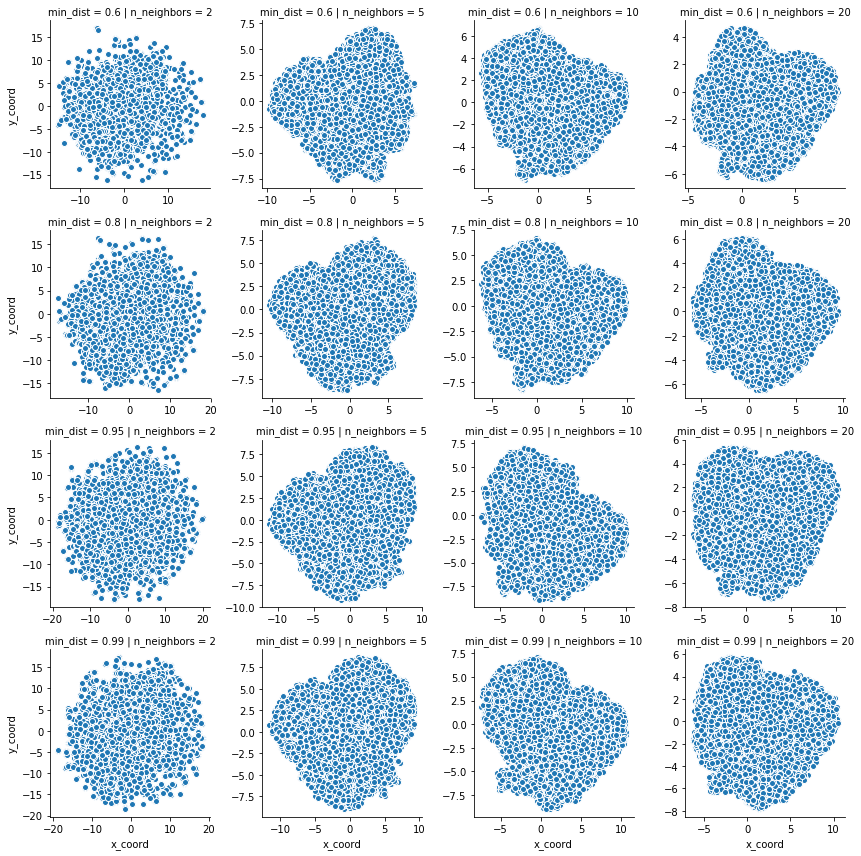

In [86]:
g = (sns.FacetGrid(umap_results, col="n_neighbors", row="min_dist", sharex = False, sharey = False)
    .map(plt.scatter, "x_coord", "y_coord", edgecolor="w")
)

In [100]:
umap_results['x_coord'] = umap_results.x_coord
umap_results['y_coord'] = -umap_results.y_coord

In [101]:
(umap_results
     .loc[
        (umap_results.n_neighbors == 10) & \
        (umap_results.min_dist == 0.8) & \
        ((umap_results.word_count > 30) |
        (umap_results.word.str.contains("_"))),
        ['word', 'word_count', 'x_coord', 'y_coord', 'rank']
     ].reset_index(drop = True)
      .to_csv('../data/umap.csv', index = False)
)

In [102]:
! mv ../data/umap.csv ../D3/newspapers/umap.csv

## Topic model

In [88]:
sentences = (papers
     .groupby(['newspaper_id', 'year', 'month', 'day', 'id', 'paragraph', 'sentence'])
     .agg({'phrase': lambda x: ' '.join(x).strip()})
     .reset_index()
)
sentences = sentences[sentences.phrase.str.len() > 0]
sentences

,newspaper_id,year,month,day,id,paragraph,sentence,phrase
3,AMW,1848,04,25,2.1,"STttttauam non paratu*,","STttttauam non paratu*,",paratu
4,AMW,1848,04,25,2.1,THE ANGLO-MAORI WARDER.,THE ANGLO-MAORI WARDER.,maori
18,AMW,1848,04,25,2.10,""" Chesham-place, Dec. 8, 1847. 4< My Lords, —I...",RepUß Professor of Divinity.,repu
22,AMW,1848,04,25,2.10,""" Chesham-place, Dec. 8, 1847. 4< My Lords, —I...",should virtually assent to the doctrine that a...,e
27,AMW,1848,04,25,2.10,Protest of the Bishops. The following importan...,"Bath AM/Wr.Lw *' J. H. Glocbstbr and Bristol ""...",e
...,...,...,...,...,...,...,...,...
796406,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,E pera ia rue te rakau whakato Kite parenga o ...,e pera ia te rakau whakato parenga o nga awa w...
796407,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,"Ko te hunga kino ia, ekore e penei, E rite ana...",ko te hunga kino ia ekore e penei e ana papapa...
796408,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,"Otira, ko tana whakaahuarekatanga Kei te ture ...",otira ko tana whakaahuarekatanga kei te ture i...
796409,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,TE I. Tau ana te manaakitanga kite tangata Kao...,te tau ana te manaakitanga tangata kaore e hae...


In [37]:
paragraphs = (papers
     .groupby(['newspaper_id', 'year', 'month', 'day', 'id', 'paragraph'])
     .agg({'phrase': lambda x: ' '.join(x).strip()})
     .reset_index()
)
paragraphs = paragraphs[paragraphs.phrase.str.len() > 0]
paragraphs

,newspaper_id,year,month,day,id,paragraph,phrase
2,AMW,1848,04,25,2.1,"STttttauam non paratu*,",paratu
3,AMW,1848,04,25,2.1,THE ANGLO-MAORI WARDER.,maori
5,AMW,1848,04,25,2.10,""" Chesham-place, Dec. 8, 1847. 4< My Lords, —I...",repu e
7,AMW,1848,04,25,2.10,Protest of the Bishops. The following importan...,e
9,AMW,1848,04,25,2.12,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.,ko te kai whakamataara o nga iwi erua
...,...,...,...,...,...,...,...
92913,WHETU,1858,09,01,2.6,UPOKO IV. I te tau o te Ariki 67 ka hapainga m...,upoko te tau o te ariki ka hapainga mai te tau...
92914,WHETU,1858,09,01,2.6,nga he ki nga Hurai kihai nei i whakapono kiat...,nga ki nga hurai kihai nei whakapono kiate kar...
92915,WHETU,1858,09,01,2.6,"otira, kihai a Hiha i whakaae kia noho ratou k...",otira kihai hiha whakaae kia noho ratou ki te ...
92916,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,te tau ana te manaakitanga tangata kaore e hae...


In [179]:
from scipy.linalg import norm

In [180]:
paragraphs['word_vector'] = paragraphs.phrase.apply(model.get_word_vector).apply(lambda x: x / norm(x))

In [181]:
paragraph_matrix = np.vstack(paragraphs.word_vector)

In [182]:
reducer = UMAP(n_components = 5, n_neighbors = 10, min_dist = 0.8)
reduced = reducer.fit_transform(paragraph_matrix)

In [183]:
reduced.shape

(84561, 5)

In [184]:
from sklearn.cluster import DBSCAN

In [275]:
clusters = DBSCAN(metric='cosine', eps=0.001, min_samples=50).fit_predict(reduced)

num_clusters = len(np.unique(clusters))
print("{} clusters identified".format(num_clusters))

paragraphs['cluster'] = clusters
cluster_data = paragraphs.groupby('cluster').agg({'phrase': lambda s: ' '.join(s).strip()}).reset_index()
cluster_data.phrase

66 clusters identified


0     paratu repu     e ko te kai whakamataara o nga...
1     maori maori maori maori maori maori maori maor...
2     e e e e e e e e ina e e e e e e e e e e e e e ...
3     o o o o o o o o o o o o o o o o o o o o o o o ...
4     te te te te te te te te te te te te te te te t...
                            ...                        
61    waka maori waka maori waka maori waka maori wa...
62    wharangi_tuwhera nga hoa tuhi mai wharangi_tuw...
63    wharangi_tuwhera wharangi_tuwhera wharangi_tuw...
64    te wananga te wananga te wananga te wananga te...
65    tihe_mauri tihe_mauri tihe_mauri tihe_mauri ti...
Name: phrase, Length: 66, dtype: object

In [276]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [277]:
tfidf = TfidfVectorizer()

In [278]:
X = tfidf.fit_transform(cluster_data.phrase)

In [279]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]

In [280]:
X = X.toarray()

In [281]:
feature_names = tfidf.get_feature_names()

In [306]:
np.sum(X > 0, axis = 1)

array([123984,      1,      5,      3,      1,     20,      1,    154,
           38,      1,      2,      1,      6,      5,      3,      1,
            2,     28,      8,      4,      3,     11,    389,      1,
            1,    127,     13,      1,     62,     16,      2,     15,
           22,     18,    222,      5,      7,      4,     28,     13,
           15,      1,     22,      1,    336,     17,      1,     15,
           54,      6,      1,      5,     16,      4,     16,    114,
            6,      4,      8,    197,      9,      3,     15,      1,
           13,      2])

In [320]:
[m for m in dir(model) if not m.startswith('_')]

['bucket',
 'dim',
 'epoch',
 'f',
 'get_analogies',
 'get_dimension',
 'get_input_matrix',
 'get_input_vector',
 'get_label_id',
 'get_labels',
 'get_line',
 'get_meter',
 'get_nearest_neighbors',
 'get_output_matrix',
 'get_sentence_vector',
 'get_subword_id',
 'get_subwords',
 'get_word_id',
 'get_word_vector',
 'get_words',
 'is_quantized',
 'label',
 'labels',
 'loss',
 'lr',
 'lrUpdateRate',
 'maxn',
 'minCount',
 'minCountLabel',
 'minn',
 'neg',
 'predict',
 'pretrainedVectors',
 'quantize',
 'save_model',
 'set_args',
 'set_matrices',
 't',
 'test',
 'test_label',
 'thread',
 'verbose',
 'wordNgrams',
 'words',
 'ws']

In [359]:
model.get_analogies('patuone', 'maori', 'kawana_kerei')

[(0.6330018043518066, 'tamehana'),
 (0.6073452234268188, 'titore'),
 (0.5655668377876282, 'matutaera'),
 (0.5473095774650574, 'takerei'),
 (0.5456271767616272, 'kingika'),
 (0.534127414226532, 'kawanana'),
 (0.5220016837120056, 'hone_wetere'),
 (0.5199105739593506, 'hemara'),
 (0.5174616575241089, 'kawana_paipai'),
 (0.5144268274307251, 'wiremu_tamihana')]

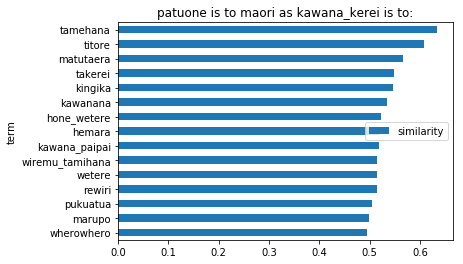

In [362]:
def get_analogies(termA, termB, termC, k=15):
    return (pd.DataFrame(
        model.get_analogies(termA, termB, termC, k=k), 
        columns = ['similarity', 'term'])
       .sort_values('similarity')
       .plot(kind = 'barh', x = 'term', y = 'similarity', title = '{} is to {} as {} is to:'.format(termA, termB, termC))
    )


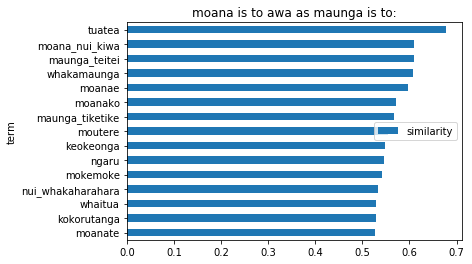

In [364]:
get_analogies('moana', 'awa', 'maunga')

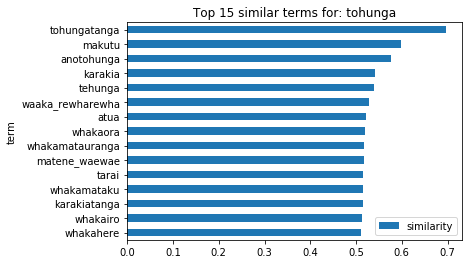

In [350]:
def get_similar_terms(term, k = 15):
    return (pd.DataFrame(
        model.get_nearest_neighbors(term, k=k), 
        columns = ['similarity', 'term'])
       .sort_values('similarity')
       .plot(kind = 'barh', x = 'term', y = 'similarity', title = 'Top {} similar terms for: {}'.format(k, term))
    )
    
get_similar_terms('tohunga')

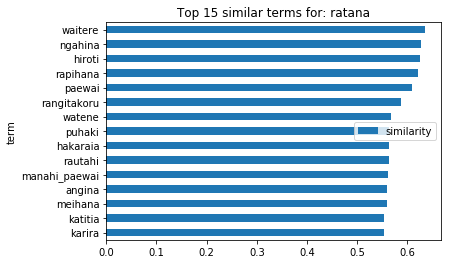

In [367]:
get_similar_terms('ratana')

In [284]:
num_top_words = 5
top_words = []
for i in range(num_clusters):
    tfidf_counts = X[i,:]
    sort_indices = np.argsort(-tfidf_counts)
    top_words.append([feature_names[idx] for idx in sort_indices[:num_top_words]])

In [285]:
print('\n\n'.join([' '.join(s) for s in top_words]))

te nga ki ka ana

maori aae riroo rironi rirongo

kia kaua ina ano mea

rote roto nui rirongo rirongii

te riroo rironi rirongo rirongii

mo ino te eimo iuane

maori aae riroo rironi rirongo

te ka ki mo paraoa

nama tau te uu uo

ihe aae riroo rironi rirongo

taranaki tarana aae rironi rirongo

waikato aae riroo rironi rirongo

mauri mahi oka mauriora towu

aotearoa paunui tearoa ko te

pukapuka ukapuka whare rirooea riroo

akarana rirooea riroo rironi rirongo

upoko upoki riroo rironi rirongo

kupu tuhi hoa enei atu

maehe okoha tokio pari niu

panuitanga uitanga anuitanga wharangi aae

nama te anama riroo rironi

huia kotahi tangata aitua mano

reta tukua mai nga te

tangata aae rirongo rirongii rirongi

heretaunga aae rirooea riroo rironi

korero rongo nga hatihana hone

nui_tireni waho waea motu atu

tupapaku aae rironi rirongo rirongii

panui ko te riutenata papawai

pitopito_korero pitopito nga pito horero

whanganui pipiriki aae rirooea riroo

tiupiri te mo tiupi apihi

hikuran